In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from datetime import datetime, timedelta
import requests
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set up visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Blues_r")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
# Mount Google Drive (if needed)
from google.colab import drive
# drive.mount('/content/drive')

print("Flight Delay Prediction Project Setup Complete")

Mounted at /content/drive
Flight Delay Prediction Project Setup Complete


In [ ]:
# # Download from Kaggle
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d bulter22/airline-data
# !unzip airline-data.zip

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/bulter22/airline-data
License(s): CC0-1.0
 99% 4.18G/4.20G [00:51<00:00, 135MB/s]
100% 4.20G/4.20G [00:51<00:00, 87.7MB/s]
Archive:  airline-data.zip
  inflating: airline.csv.shuffle     
  inflating: carriers.csv            


In [ ]:
# Sample flight data (limited subset)
# airline data that's commonly available
url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
column_names = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO',
                'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST',
                'Tz database time zone', 'Type', 'Source']
airports = pd.read_csv(url, header=None, names=column_names)

In [ ]:
def generate_synthetic_flight_data(n_samples=10000):
    """Generate synthetic flight data based on common airline patterns"""
    # Airport selection
    major_airports = airports[airports['Country'] == 'United States'].sample(20)

    # Dates
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 3, 31)
    dates = [start_date + timedelta(days=x) for x in range((end_date - start_date).days)]

    # Airlines
    airlines = ['AA', 'DL', 'UA', 'WN', 'B6', 'AS', 'NK', 'F9']

    # Generate data
    np.random.seed(42)
    data = {
        'FlightDate': np.random.choice(dates, n_samples),
        'Airline': np.random.choice(airlines, n_samples),
        'Origin': np.random.choice(major_airports['IATA'].values, n_samples),
        'Dest': np.random.choice(major_airports['IATA'].values, n_samples),
        'DepTime': np.random.randint(600, 2200, n_samples),
        'ArrTime': np.random.randint(700, 2300, n_samples),
        'Distance': np.random.randint(100, 3000, n_samples),
        'DayOfWeek': np.random.randint(1, 8, n_samples)
    }

    # Add delay data - skewed distribution to reflect reality
    base_delays = np.random.exponential(scale=15, size=n_samples)
    seasonal_factor = np.sin(np.array([d.timetuple().tm_yday for d in data['FlightDate']]) * 2 * np.pi / 365) * 10
    distance_factor = data['Distance'] * 0.01
    time_of_day_factor = np.abs(np.array([t - 1200 for t in data['DepTime']])) * 0.02

    # Generate departure delays
    data['DepDelay'] = np.maximum(0, base_delays + seasonal_factor + distance_factor * 0.1 + time_of_day_factor)

    # Generate arrival delays (correlated with departure delays)
    data['ArrDelay'] = data['DepDelay'] * 0.8 + np.random.normal(0, 5, n_samples)

    # Weather data - simplified for demo
    data['WindSpeed'] = np.random.exponential(scale=8, size=n_samples) + seasonal_factor * 0.5
    data['Precipitation'] = np.random.exponential(scale=0.2, size=n_samples) + np.maximum(0, seasonal_factor * 0.05)
    data['Temperature'] = 70 + seasonal_factor + np.random.normal(0, 5, n_samples)
    data['Visibility'] = np.maximum(1, 10 - data['Precipitation'] * 10 + np.random.normal(0, 2, n_samples))

    # Airport congestion (proxy)
    unique_dates = np.array(sorted(set(d.strftime('%Y-%m-%d') for d in data['FlightDate'])))
    unique_origins = np.array(sorted(set(data['Origin'])))

    # Create a dictionary for date-airport congestion
    congestion_map = {}
    for date in unique_dates:
        for airport in unique_origins:
            # Base level plus seasonal and random factors
            base = np.random.gamma(shape=5, scale=3)
            day_idx = np.where(unique_dates == date)[0][0]
            seasonal = np.sin(day_idx * 2 * np.pi / len(unique_dates)) * 5
            congestion_map[(date, airport)] = base + seasonal + np.random.normal(0, 2)

    # Map congestion to flights
    data['OriginCongestion'] = [
        congestion_map.get((d.strftime('%Y-%m-%d'), o), 5)
        for d, o in zip(data['FlightDate'], data['Origin'])
    ]

    data['DestCongestion'] = [
        congestion_map.get((d.strftime('%Y-%m-%d'), dest), 5)
        for d, dest in zip(data['FlightDate'], data['Dest'])
    ]

    # Round numeric values to make them more realistic
    for col in ['DepDelay', 'ArrDelay', 'WindSpeed', 'Precipitation',
                'Temperature', 'Visibility', 'OriginCongestion', 'DestCongestion']:
        data[col] = np.round(data[col], 1)

    # Convert to dataframe
    df = pd.DataFrame(data)

    # Convert FlightDate to string for easier handling
    df['FlightDate'] = df['FlightDate'].apply(lambda x: x.strftime('%Y-%m-%d'))

    return df

In [ ]:
# Generate our synthetic data
flights_df = generate_synthetic_flight_data(15000)

# Display the first few rows to understand the data
print("Sample of the flight data:")
print(flights_df.head())

# Basic data exploration
print("\nData dimensions:", flights_df.shape)
print("\nData types:")
print(flights_df.dtypes)

print("\nSummary statistics for numerical columns:")
print(flights_df.describe())

# Check for missing values
print("\nMissing values per column:")
print(flights_df.isnull().sum())

# Convert date column to datetime
flights_df['FlightDate'] = pd.to_datetime(flights_df['FlightDate'])

# Extract useful date features
flights_df['Month'] = flights_df['FlightDate'].dt.month
flights_df['DayOfMonth'] = flights_df['FlightDate'].dt.day
flights_df['Quarter'] = flights_df['FlightDate'].dt.quarter
flights_df['IsWeekend'] = flights_df['DayOfWeek'].apply(lambda x: 1 if x >= 6 else 0)

Sample of the flight data:
   FlightDate Airline Origin Dest  DepTime  ArrTime  Distance  DayOfWeek  \
0  2023-02-21      NK    GLV  IAB     1714     2007      2041          7   
1  2023-01-15      F9    SWF   \N      973     1030      2158          2   
2  2023-03-13      AA    LRU  SEA      803      935      2501          7   
3  2023-03-02      B6     \N   \N     1208     1561      2097          1   
4  2023-01-21      AA    HKY  LRU     1232      984      1932          7   

   DepDelay  ArrDelay  WindSpeed  Precipitation  Temperature  Visibility  \
0      88.0      74.1       10.3            0.7         70.9         9.7   
1      23.8      28.2        8.1            0.5         76.5         8.1   
2      45.7      35.0       17.0            0.6         85.1         5.8   
3      34.0      30.1        6.6            0.5         85.8         6.6   
4       7.8       7.5        3.3            0.2         75.8         8.3   

   OriginCongestion  DestCongestion  
0               7.5  

Text(0, 0.5, 'Average Delay (minutes)')

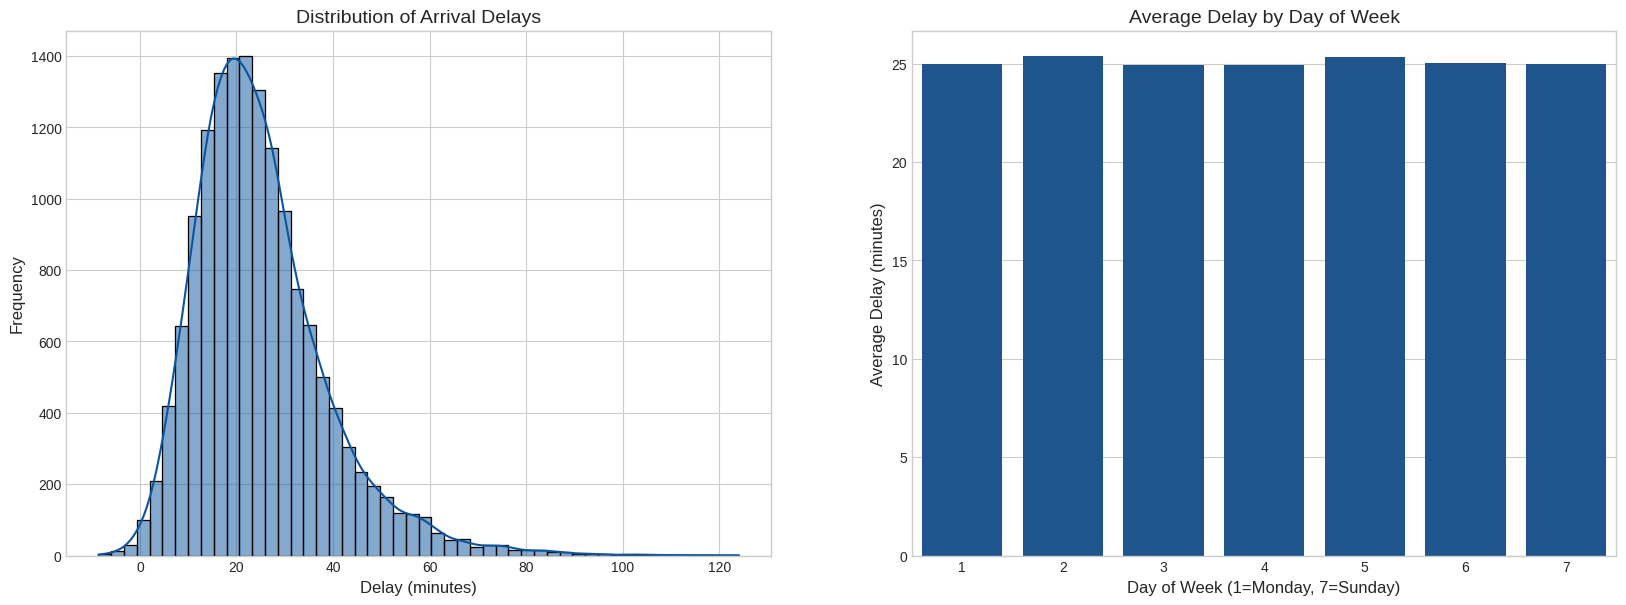

In [ ]:
# Part 2: Data Visualization
# --------------------------

# Set up a figure for visualizations
plt.figure(figsize=(20, 15))

# Plot 1: Distribution of arrival delays
plt.subplot(2, 2, 1)
sns.histplot(flights_df['ArrDelay'], kde=True, bins=50)
plt.title('Distribution of Arrival Delays', fontsize=14)
plt.xlabel('Delay (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Plot 2: Average delay by day of week
plt.subplot(2, 2, 2)
day_delay = flights_df.groupby('DayOfWeek')['ArrDelay'].mean().reset_index()
sns.barplot(x='DayOfWeek', y='ArrDelay', data=day_delay)
plt.title('Average Delay by Day of Week', fontsize=14)
plt.xlabel('Day of Week (1=Monday, 7=Sunday)', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)



Text(0, 0.5, 'Arrival Delay (minutes)')

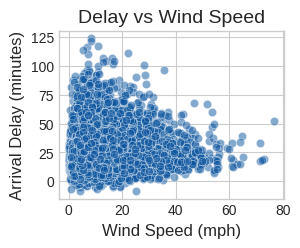

In [ ]:
# Plot 3: Delay correlation with weather conditions
plt.subplot(2, 2, 3)
sns.scatterplot(x='WindSpeed', y='ArrDelay', data=flights_df, alpha=0.5)
plt.title('Delay vs Wind Speed', fontsize=14)
plt.xlabel('Wind Speed (mph)', fontsize=12)
plt.ylabel('Arrival Delay (minutes)', fontsize=12)

TypeError: Invalid object type at position 0

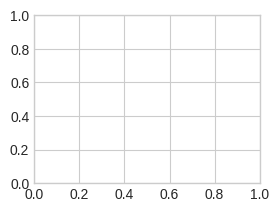

In [ ]:
# Plot 4: Delay by origin airport congestion
plt.subplot(2, 2, 4)
congestion_delay = flights_df.groupby(pd.cut(flights_df['OriginCongestion'], bins=10))['ArrDelay'].mean().reset_index()
sns.lineplot(x='OriginCongestion', y='ArrDelay', data=congestion_delay)
plt.title('Average Delay by Origin Airport Congestion', fontsize=14)
plt.xlabel('Congestion Level', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)

plt.tight_layout()
plt.show()

# More insightful visualizations
plt.figure(figsize=(20, 15))

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

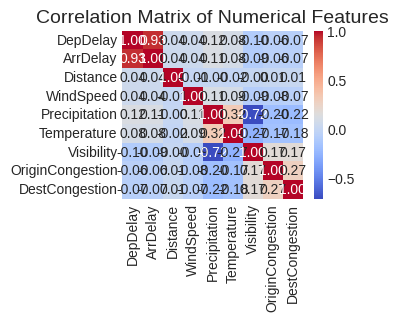

In [ ]:
# Plot 5: Correlation heatmap
plt.subplot(2, 2, 1)
numeric_cols = ['DepDelay', 'ArrDelay', 'Distance', 'WindSpeed',
                'Precipitation', 'Temperature', 'Visibility',
                'OriginCongestion', 'DestCongestion']
corr = flights_df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=14)

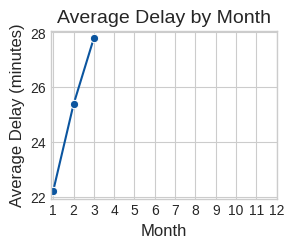

In [ ]:
# Plot 6: Average delay by month (seasonal patterns)
plt.subplot(2, 2, 2)
month_delay = flights_df.groupby('Month')['ArrDelay'].mean().reset_index()
sns.lineplot(x='Month', y='ArrDelay', data=month_delay, marker='o')
plt.title('Average Delay by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(True)

Text(0, 0.5, 'Average Delay (minutes)')

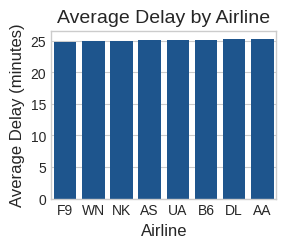

In [ ]:
# Plot 7: Delay by airline
plt.subplot(2, 2, 3)
airline_delay = flights_df.groupby('Airline')['ArrDelay'].mean().sort_values().reset_index()
sns.barplot(x='Airline', y='ArrDelay', data=airline_delay)
plt.title('Average Delay by Airline', fontsize=14)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)

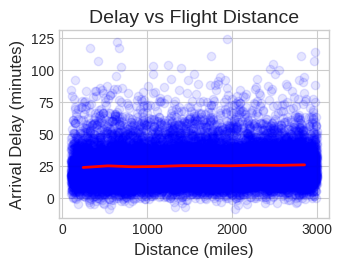

In [ ]:
# Plot 8: Delay vs Distance
plt.subplot(2, 2, 4)
# Group by distance ranges to see patterns
distance_bins = pd.cut(flights_df['Distance'], bins=10)
distance_delay = flights_df.groupby(distance_bins)['ArrDelay'].mean().reset_index()
plt.scatter(flights_df['Distance'], flights_df['ArrDelay'], alpha=0.1, c='blue')
plt.plot(distance_delay['Distance'].apply(lambda x: x.mid), distance_delay['ArrDelay'], 'r-', linewidth=2)
plt.title('Delay vs Flight Distance', fontsize=14)
plt.xlabel('Distance (miles)', fontsize=12)
plt.ylabel('Arrival Delay (minutes)', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Part 3: Feature Engineering
# ---------------------------

# Create time-based features
flights_df['Hour'] = flights_df['DepTime'] // 100
flights_df['IsRushHour'] = ((flights_df['Hour'] >= 7) & (flights_df['Hour'] <= 9)) | ((flights_df['Hour'] >= 16) & (flights_df['Hour'] <= 19))

# Create a feature for "hub airports" (simplified using Origin frequency)
origin_counts = flights_df['Origin'].value_counts()
hub_airports = origin_counts[origin_counts > origin_counts.quantile(0.75)].index.tolist()
flights_df['IsOriginHub'] = flights_df['Origin'].apply(lambda x: 1 if x in hub_airports else 0)

dest_counts = flights_df['Dest'].value_counts()
hub_dest_airports = dest_counts[dest_counts > dest_counts.quantile(0.75)].index.tolist()
flights_df['IsDestHub'] = flights_df['Dest'].apply(lambda x: 1 if x in hub_dest_airports else 0)

# Create weather severity features
flights_df['WeatherSeverity'] = (
    flights_df['WindSpeed'] / 10 +
    flights_df['Precipitation'] * 5 +
    (10 - flights_df['Visibility']) / 2
)

# Feature for previous flight delay (simplified version)
# In a real implementation, you would create a more accurate chain of flights
flights_df = flights_df.sort_values(['Origin', 'FlightDate', 'DepTime'])
flights_df['PrevFlightDelayAtOrigin'] = flights_df.groupby(['Origin', 'FlightDate'])['DepDelay'].shift(1)
flights_df['PrevFlightDelayAtOrigin'].fillna(0, inplace=True)

# Show the new features
print("\nDataset with engineered features:")
print(flights_df.head())



Dataset with engineered features:
      FlightDate Airline Origin Dest  DepTime  ArrTime  Distance  DayOfWeek  \
10148 2023-01-01      DL    ALI   \N      786     1995      2966          5   
12817 2023-01-01      B6    ALI  HKY     1254     1376      2346          2   
2937  2023-01-01      AS    ALI  CLL     1261      975      2537          7   
10730 2023-01-01      WN    ALI   \N     1349     1574      2064          1   
972   2023-01-01      UA    ALI   \N     1640     1482      1844          3   

       DepDelay  ArrDelay  WindSpeed  Precipitation  Temperature  Visibility  \
10148      22.4      21.5       23.6            0.7         79.7         3.6   
12817      14.9       7.7       27.9            0.2         76.5         8.4   
2937        4.9      10.9       18.5            0.6         71.4         6.5   
10730       7.0       4.3       11.6            0.0         76.9         8.8   
972        36.2      24.6        2.1            0.2         75.7         5.7   

       Or

In [ ]:
# Part 4: Data Preparation for Modeling
# -------------------------------------

# Select our target variable
target = 'ArrDelay'

# We'll focus on predicting arrival delays, which is the most relevant for passengers
# Select features we'll use in our model
features = [
    'Month', 'DayOfMonth', 'DayOfWeek', 'DepTime', 'Distance',
    'WindSpeed', 'Precipitation', 'Temperature', 'Visibility',
    'OriginCongestion', 'DestCongestion', 'IsWeekend', 'Hour',
    'IsRushHour', 'IsOriginHub', 'IsDestHub', 'WeatherSeverity',
    'PrevFlightDelayAtOrigin', 'Airline', 'Origin', 'Dest'
]

# Remove rows with missing values for simplicity
# In production, you'd want to use imputation strategies
flights_df = flights_df.dropna(subset=features + [target])

# Split dataset into features and target
X = flights_df[features]
y = flights_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Identify categorical and numerical features
categorical_features = ['Airline', 'Origin', 'Dest']
numerical_features = [col for col in features if col not in categorical_features]

# Create preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Training set size: 12000 samples
Testing set size: 3000 samples



Training XGBoost model...
Training Random Forest model...

XGBoost Model Performance:
Mean Absolute Error: 9.87 minutes
Root Mean Squared Error: 13.33 minutes
R² Score: 0.1033

Random Forest Model Performance:
Mean Absolute Error: 9.94 minutes
Root Mean Squared Error: 13.40 minutes
R² Score: 0.0931

Top 15 Features by XGBoost Importance:
                         Feature  Importance
12                     num__Hour    0.130540
3                   num__DepTime    0.054017
0                     num__Month    0.046057
40               cat__Origin_SEA    0.020676
57                 cat__Dest_SEA    0.018937
55                 cat__Dest_PAO    0.018552
39               cat__Origin_PTT    0.018261
59                  cat__Dest_\N    0.017770
13               num__IsRushHour    0.017351
35               cat__Origin_MTC    0.016646
16          num__WeatherSeverity    0.015776
54                 cat__Dest_OLV    0.015649
51                 cat__Dest_MSP    0.015526
8                num__Visibil

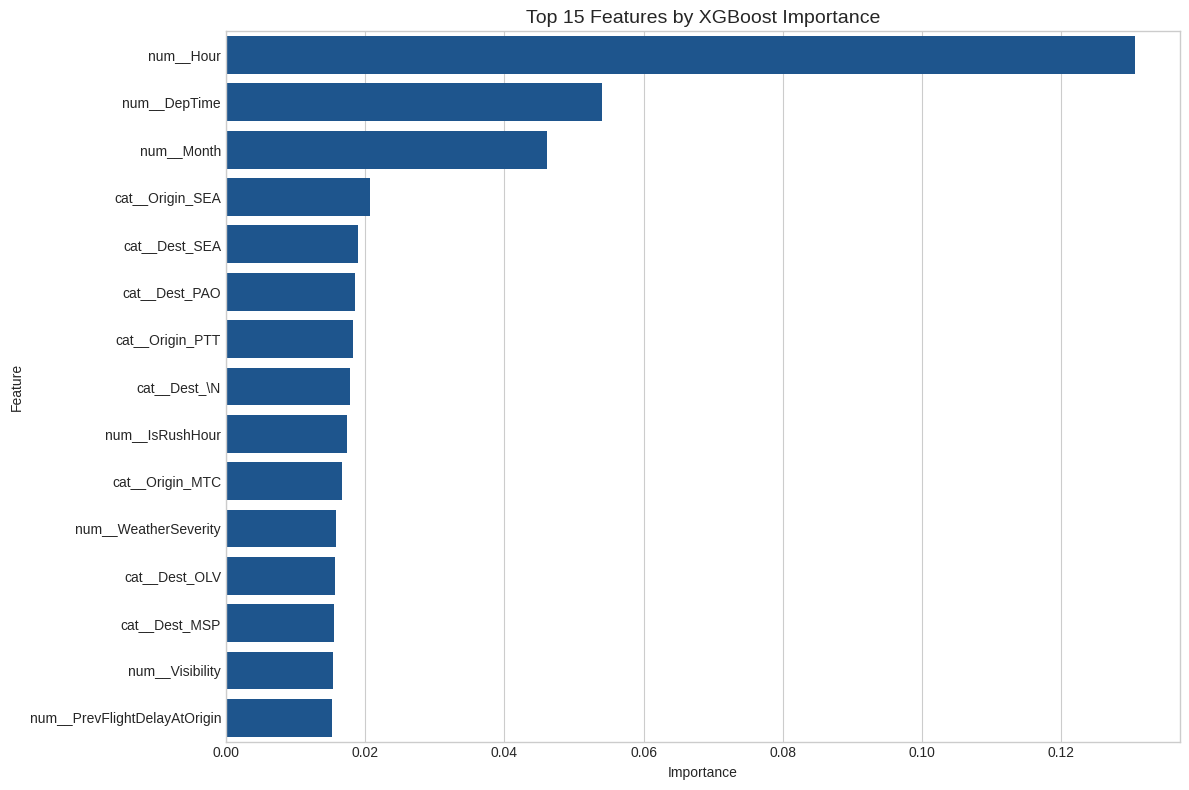

In [ ]:
# Part 5: Model Building and Evaluation
# -------------------------------------

# Create XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ))
])

# Create Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Train XGBoost model
print("\nTraining XGBoost model...")
xgb_pipeline.fit(X_train, y_train)

# Train Random Forest model
print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_train)

# Make predictions with both models
xgb_y_pred = xgb_pipeline.predict(X_test)
rf_y_pred = rf_pipeline.predict(X_test)

# Evaluate XGBoost performance
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
xgb_r2 = r2_score(y_test, xgb_y_pred)

# Evaluate Random Forest performance
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
rf_r2 = r2_score(y_test, rf_y_pred)

print("\nXGBoost Model Performance:")
print(f"Mean Absolute Error: {xgb_mae:.2f} minutes")
print(f"Root Mean Squared Error: {xgb_rmse:.2f} minutes")
print(f"R² Score: {xgb_r2:.4f}")

print("\nRandom Forest Model Performance:")
print(f"Mean Absolute Error: {rf_mae:.2f} minutes")
print(f"Root Mean Squared Error: {rf_rmse:.2f} minutes")
print(f"R² Score: {rf_r2:.4f}")

# Part 6: Feature Importance Analysis
# -----------------------------------

# Get feature importance from XGBoost model
# We need to extract the feature names after one-hot encoding
preprocessor_xgb = xgb_pipeline.named_steps['preprocessor']
model_xgb = xgb_pipeline.named_steps['model']

# Apply transformation to get feature names
X_train_processed = preprocessor_xgb.transform(X_train)

# Get feature names after preprocessing
if hasattr(preprocessor_xgb, 'get_feature_names_out'):
    # For newer scikit-learn versions
    feature_names = preprocessor_xgb.get_feature_names_out()
else:
    # For older scikit-learn versions
    feature_names = []
    for name, trans, cols in preprocessor_xgb.transformers_:
        if name != 'remainder':
            if hasattr(trans, 'get_feature_names_out'):
                feature_names.extend(trans.get_feature_names_out(cols))
            else:
                # Fallback for older versions or custom transformers
                for col in cols:
                    feature_names.append(f"{name}__{col}")

# Get feature importances from models
if hasattr(model_xgb, 'feature_importances_'):
    xgb_importances = model_xgb.feature_importances_
    xgb_features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': xgb_importances
    }).sort_values('Importance', ascending=False)

    # Display top features
    print("\nTop 15 Features by XGBoost Importance:")
    print(xgb_features_df.head(15))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=xgb_features_df.head(15))
    plt.title('Top 15 Features by XGBoost Importance', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Part 7: Predictions and Visualization
# ------------------------------------

# Create a function to predict delays for new data
def predict_delay(model, flight_data):
    """
    Predict flight delay using the trained model
    """
    return model.predict(flight_data)

# Let's create a sample flight to predict
# Instead of iloc[[0]], using sample to randomly select a flight record
sample_flight = X_test.sample(n=1, random_state=42)

# Display the sample flight details
print("\nSample Flight Details:")
for col in sample_flight.columns:
    print(f"{col}: {sample_flight[col].values[0]}")

# Predict delay for the sample flight
xgb_predicted_delay = predict_delay(xgb_pipeline, sample_flight)
rf_predicted_delay = predict_delay(rf_pipeline, sample_flight)

# Instead of using y_test.iloc[0], using sample_flight to get corresponding Actual Delay
actual_delay = y_test[sample_flight.index[0]]

print(f"\nXGBoost Predicted Delay: {xgb_predicted_delay[0]:.2f} minutes")
print(f"Random Forest Predicted Delay: {rf_predicted_delay[0]:.2f} minutes")
print(f"Actual Delay: {actual_delay:.2f} minutes")


Sample Flight Details:
Month: 1
DayOfMonth: 22
DayOfWeek: 2
DepTime: 1403
Distance: 2868
WindSpeed: 17.0
Precipitation: 0.5
Temperature: 78.1
Visibility: 4.3
OriginCongestion: 19.5
DestCongestion: 17.0
IsWeekend: 0
Hour: 14
IsRushHour: False
IsOriginHub: 1
IsDestHub: 0
WeatherSeverity: 7.050000000000001
PrevFlightDelayAtOrigin: 37.6
Airline: UA
Origin: \N
Dest: HOT

XGBoost Predicted Delay: 26.72 minutes
Random Forest Predicted Delay: 22.24 minutes
Actual Delay: 2.20 minutes


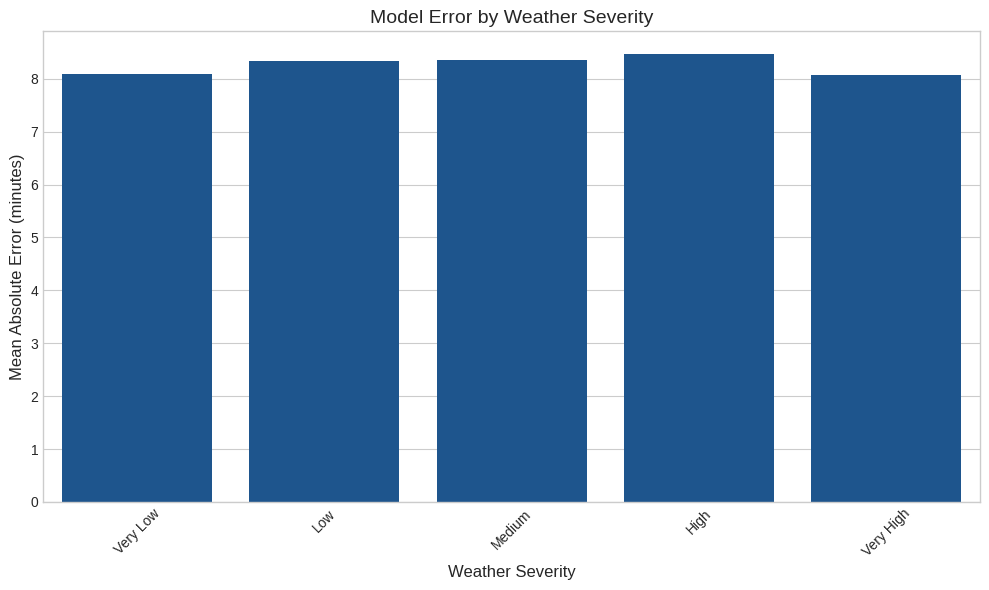

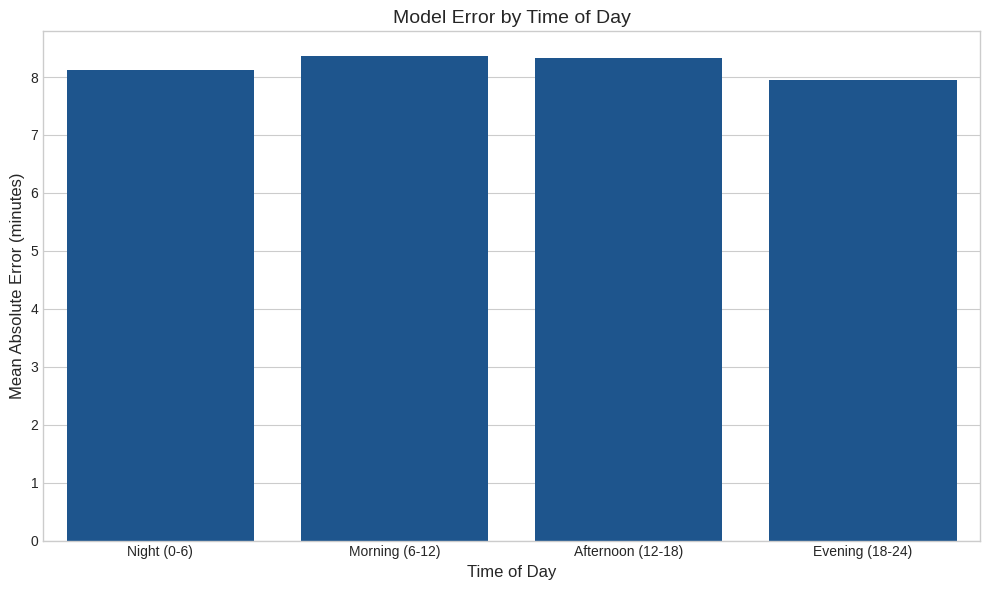

In [ ]:
# Part 8: Model Performance Across Different Conditions
# ---------------------------------------------------

# Analyze model performance under different weather conditions
flights_df['PredictedDelay_XGB'] = xgb_pipeline.predict(flights_df[features])

# Create a "weather severity" bin for analysis
flights_df['WeatherSeverityBin'] = pd.qcut(flights_df['WeatherSeverity'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Calculate error by weather severity
error_by_weather = flights_df.groupby('WeatherSeverityBin').apply(
    lambda x: mean_absolute_error(x['ArrDelay'], x['PredictedDelay_XGB'])
).reset_index()
error_by_weather.columns = ['Weather Severity', 'MAE']

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Weather Severity', y='MAE', data=error_by_weather)
plt.title('Model Error by Weather Severity', fontsize=14)
plt.ylabel('Mean Absolute Error (minutes)', fontsize=12)
plt.xlabel('Weather Severity', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze by time of day
flights_df['TimeOfDayBin'] = pd.cut(
    flights_df['Hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
)

error_by_time = flights_df.groupby('TimeOfDayBin').apply(
    lambda x: mean_absolute_error(x['ArrDelay'], x['PredictedDelay_XGB'])
).reset_index()
error_by_time.columns = ['Time of Day', 'MAE']

plt.figure(figsize=(10, 6))
sns.barplot(x='Time of Day', y='MAE', data=error_by_time)
plt.title('Model Error by Time of Day', fontsize=14)
plt.ylabel('Mean Absolute Error (minutes)', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Part 9: Next Steps for Implementation
# ------------------------------------

print("\nNext Steps for Implementation:")
print("1. Fetch real flight data from sources like BTS and Kaggle instead of synthetic data")
print("2. Integrate with real-time NOAA weather API")
print("3. Add FAA ASPM data for runway and gate usage statistics")
print("4. Implement model hyperparameter tuning using cross-validation")
print("5. Create a model refresh pipeline to retrain with new data")
print("6. Develop a web interface for real-time predictions")
print("7. Add alerting functionality for predicted high-delay situations")
print("8. Integrate with airport congestion datasets")


Next Steps for Implementation:
1. Fetch real flight data from sources like BTS and Kaggle instead of synthetic data
2. Integrate with real-time NOAA weather API
3. Add FAA ASPM data for runway and gate usage statistics
4. Implement model hyperparameter tuning using cross-validation
5. Create a model refresh pipeline to retrain with new data
6. Develop a web interface for real-time predictions
7. Add alerting functionality for predicted high-delay situations
8. Integrate with airport congestion datasets


In [ ]:
# Part 10: Simulating Real-Time Integration
# ----------------------------------------
# Part 10: Simulating Real-Time Integration
# ----------------------------------------

# Simulating real-time weather API integration
def get_weather_data(airport_code, date):
    """
    Simulate getting weather data from NOAA API
    In a real implementation, this would make an actual API call
    """
    # This is a simulation - in a real implementation, use requests to call the NOAA API
    np.random.seed(hash(f"{airport_code}_{date}") % 2**32)

    # Simulate seasonal patterns
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    day_of_year = date_obj.timetuple().tm_yday
    seasonal_factor = np.sin(day_of_year * 2 * np.pi / 365)

    # Generate realistic weather data
    weather_data = {
        'airport': airport_code,
        'date': date,
        'temperature': round(70 + seasonal_factor * 20 + np.random.normal(0, 5), 1),
        'wind_speed': round(max(0, 8 + seasonal_factor * 5 + np.random.normal(0, 3)), 1),
        'precipitation': round(max(0, 0.1 + seasonal_factor * 0.3 + np.random.exponential(0.2)), 2),
        'visibility': round(max(1, 10 - seasonal_factor * 2 - np.random.exponential(0.5)), 1)
    }

    return weather_data

# Simulate real-time prediction function
def predict_flight_delay_realtime(flight_info, weather_api_key=None):
    """
    Predict flight delay with real-time data integration

    Parameters:
    flight_info: Dictionary with flight details
    weather_api_key: API key for weather service (not used in simulation)

    Returns:
    Dictionary with prediction details
    """
    # In a real implementation, you would fetch real-time data
    # Here we're simulating the process

    # Get weather data for origin and destination
    origin_weather = get_weather_data(flight_info['origin'], flight_info['date'])
    dest_weather = get_weather_data(flight_info['destination'], flight_info['date'])

    # Create a dataframe row with all necessary features
    flight_data = pd.DataFrame({
        'Airline': [flight_info['airline']],
        'Origin': [flight_info['origin']],
        'Dest': [flight_info['destination']],
        'Month': [int(flight_info['date'].split('-')[1])],
        'DayOfMonth': [int(flight_info['date'].split('-')[2])],
        'DayOfWeek': [datetime.strptime(flight_info['date'], '%Y-%m-%d').weekday() + 1],
        'DepTime': [int(flight_info['departure_time'].replace(':', ''))],
        'Distance': [flight_info['distance']],
        'WindSpeed': [origin_weather['wind_speed']],
        'Precipitation': [origin_weather['precipitation']],
        'Temperature': [origin_weather['temperature']],
        'Visibility': [origin_weather['visibility']],
        'OriginCongestion': [flight_info.get('origin_congestion', 10)],  # Default if not provided
        'DestCongestion': [flight_info.get('dest_congestion', 10)],  # Default if not provided
        'IsWeekend': [1 if datetime.strptime(flight_info['date'], '%Y-%m-%d').weekday() >= 5 else 0],
        'Hour': [int(flight_info['departure_time'].split(':')[0])],
        'IsRushHour': [1 if (7 <= int(flight_info['departure_time'].split(':')[0]) <= 9) or
                          (16 <= int(flight_info['departure_time'].split(':')[0]) <= 19) else 0],
        'IsOriginHub': [1 if flight_info['origin'] in hub_airports else 0],
        'IsDestHub': [1 if flight_info['destination'] in hub_dest_airports else 0],
        'WeatherSeverity': [
            origin_weather['wind_speed'] / 10 +
            origin_weather['precipitation'] * 5 +
            (10 - origin_weather['visibility']) / 2
        ],
        'PrevFlightDelayAtOrigin': [flight_info.get('prev_delay', 0)]  # Default if not provided
    })

    # Use our trained model to predict delay
    predicted_delay = xgb_pipeline.predict(flight_data)[0]

    # Prepare the response
    response = {
        'flight': f"{flight_info['airline']}{flight_info.get('flight_number', '123')}",
        'origin': flight_info['origin'],
        'destination': flight_info['destination'],
        'scheduled_departure': flight_info['departure_time'],
        'predicted_delay': round(predicted_delay, 1),
        'delay_risk': 'Low' if predicted_delay < 15 else 'Medium' if predicted_delay < 30 else 'High',
        'weather_impact': 'Significant' if origin_weather['precipitation'] > 0.5 or origin_weather['wind_speed'] > 15 else 'Minimal',
        'congestion_impact': 'High' if flight_info.get('origin_congestion', 10) > 15 else 'Normal',
        'recommendation': 'No action needed' if predicted_delay < 15 else 'Consider adding buffer time' if predicted_delay < 30 else 'Consider alternative flight options'
    }

    return response

# Test the real-time prediction function with a sample flight
sample_flight_info = {
    'airline': 'DL',
    'flight_number': '1234',
    'origin': 'ATL',
    'destination': 'LAX',
    'date': '2023-03-15',
    'departure_time': '08:30',
    'distance': 1950,
    'origin_congestion': 18,
    'dest_congestion': 12,
    'prev_delay': 25
}


prediction_result = predict_flight_delay_realtime(sample_flight_info)

print("\nReal-time Prediction Example:")
print(f"Flight: {prediction_result['flight']} from {prediction_result['origin']} to {prediction_result['destination']}")
print(f"Scheduled Departure: {prediction_result['scheduled_departure']}")
print(f"Predicted Delay: {prediction_result['predicted_delay']} minutes")
print(f"Delay Risk: {prediction_result['delay_risk']}")
print(f"Weather Impact: {prediction_result['weather_impact']}")
print(f"Congestion Impact: {prediction_result['congestion_impact']}")
print(f"Recommendation: {prediction_result['recommendation']}")

# Part 11: Model Improvement Strategies
# -------------------------------------

print("\nModel Improvement Strategies:")
print("1. Hyperparameter Tuning")
print("2. Feature Selection")
print("3. Ensemble Methods")
print("4. Advanced Model Architectures")

# Let's implement a simple hyperparameter tuning example
# Note: In a real implementation, this would be much more extensive

# Define a smaller parameter grid for demonstration purposes
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1],
    'model__n_estimators': [50, 100]
}

# Use a smaller subset of data for grid search to keep it quick
X_sample = X_train.sample(n=1000, random_state=42)
y_sample = y_train.sample(n=1000, random_state=42)

# Create a new pipeline for tuning
tune_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(random_state=42))
])

print("\nPerforming hyperparameter tuning (on a small sample for demonstration)...")
grid_search = GridSearchCV(
    tune_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Fit the grid search (this may take a while)
grid_search.fit(X_sample, y_sample)

# Print best parameters
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best MAE: {-grid_search.best_score_:.2f}")

# In a real implementation, you would use these parameters to train on the full dataset
best_model = grid_search.best_estimator_

# Part 12: Advanced Feature Engineering
# ------------------------------------

print("\nAdvanced Feature Engineering:")

# Let's create some more sophisticated features for our model
# These would be more realistic with the actual datasets

# 1. Create rolling window statistics for airports
# In a real implementation, we would calculate these from historical data
def add_rolling_airport_stats(df):
    """Add rolling statistics for airports based on recent performance"""
    # Sort by date and time
    df = df.sort_values(['Origin', 'FlightDate', 'DepTime'])

    # Create 7-day rolling average delay for each origin airport
    df['Origin_7day_avg_delay'] = df.groupby('Origin')['ArrDelay'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    # Create 7-day rolling average delay for each destination airport
    df['Dest_7day_avg_delay'] = df.groupby('Dest')['ArrDelay'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    # Create 7-day rolling standard deviation for origin airport
    df['Origin_7day_std_delay'] = df.groupby('Origin')['ArrDelay'].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )

    # Fill NaN values with mean
    for col in ['Origin_7day_avg_delay', 'Dest_7day_avg_delay', 'Origin_7day_std_delay']:
        df[col] = df[col].fillna(df[col].mean())

    return df

# 2. Create time-based delay patterns
def add_time_patterns(df):
    """Add features capturing time-based delay patterns"""
    # Create hour of day as cyclical features
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)

    # Create day of week as cyclical features
    df['day_sin'] = np.sin(2 * np.pi * (df['DayOfWeek']-1)/7)
    df['day_cos'] = np.cos(2 * np.pi * (df['DayOfWeek']-1)/7)

    # Create month as cyclical features
    df['month_sin'] = np.sin(2 * np.pi * (df['Month']-1)/12)
    df['month_cos'] = np.cos(2 * np.pi * (df['Month']-1)/12)

    return df

# Apply these feature engineering functions
print("Adding advanced time-based features...")
flights_df = add_time_patterns(flights_df)

print("Adding rolling airport statistics...")
flights_df = add_rolling_airport_stats(flights_df)

print("\nNew features added:")
for col in ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
           'Origin_7day_avg_delay', 'Dest_7day_avg_delay', 'Origin_7day_std_delay']:
    print(f"- {col}")

# Part 13: Weather API Integration Simulation
# ------------------------------------------

# Let's simulate working with a weather API like NOAA
def simulate_noaa_api_call(date, location, api_key="simulated_key"):
    """
    Simulate a call to the NOAA weather API
    In a real implementation, this would make an actual API request

    Args:
        date (str): Date in YYYY-MM-DD format
        location (str): Airport code or location
        api_key (str): API key for authentication

    Returns:
        dict: Weather data
    """
    print(f"Simulating NOAA API call for {location} on {date}...")

    # In a real implementation, you would use:
    # response = requests.get(f"https://api.weather.gov/points/{lat},{lon}")
    # followed by requests to the forecast and observation endpoints

    # For this simulation, we'll just return some synthetic data
    np.random.seed(hash(f"{location}_{date}") % 2**32)

    # Parse date and get season
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    day_of_year = date_obj.timetuple().tm_yday
    season_factor = np.sin(day_of_year * 2 * np.pi / 365)

    # Create base weather conditions based on airport (simplified)
    base_conditions = {
        'ATL': {'temp': 70, 'precip': 0.1, 'wind': 8},  # Atlanta - warm, some rain
        'ORD': {'temp': 55, 'precip': 0.15, 'wind': 12},  # Chicago - cooler, windy
        'LAX': {'temp': 75, 'precip': 0.05, 'wind': 5},  # LA - warm, dry
        'JFK': {'temp': 60, 'precip': 0.2, 'wind': 10},  # NY - moderate
        'DFW': {'temp': 75, 'precip': 0.1, 'wind': 15},  # Dallas - warm, windy
    }

    # Get base conditions for this airport or use default
    base = base_conditions.get(location, {'temp': 65, 'precip': 0.1, 'wind': 8})

    # Generate weather data with seasonal variations and randomness
    weather_data = {
        'temperature': round(base['temp'] + season_factor * 15 + np.random.normal(0, 5), 1),
        'precipitation': round(max(0, base['precip'] + season_factor * 0.2 + np.random.exponential(0.1)), 2),
        'wind_speed': round(max(0, base['wind'] + season_factor * 3 + np.random.normal(0, 3)), 1),
        'visibility': round(max(1, 10 - (base['precip'] * 20) - np.random.exponential(1)), 1),
        'pressure': round(1013 + np.random.normal(0, 5), 1),
        'humidity': round(min(100, max(20, 60 + season_factor * 20 + np.random.normal(0, 10))), 1),
        'conditions': np.random.choice(
            ['Clear', 'Partly Cloudy', 'Cloudy', 'Rain', 'Thunderstorm', 'Snow'],
            p=[0.3, 0.3, 0.2, 0.1, 0.05, 0.05]
        ),
        'forecast': {
            'next_6_hours': {
                'precipitation_prob': round(min(100, max(0, base['precip'] * 100 + np.random.normal(0, 20))), 1),
                'wind_change': round(np.random.normal(0, 3), 1),
                'temp_change': round(np.random.normal(0, 3), 1)
            }
        }
    }

    return weather_data

# Example of using the simulated NOAA API
atl_weather = simulate_noaa_api_call("2023-03-15", "ATL")
print("\nWeather data for ATL:")
for key, value in atl_weather.items():
    if key != 'forecast':
        print(f"- {key}: {value}")
    else:
        print(f"- {key}:")
        for fkey, fval in value['next_6_hours'].items():
            print(f"  - {fkey}: {fval}")

# Part 14: Integration with Airport Congestion Data
# ------------------------------------------------

def simulate_faa_aspm_data(airport, date, hour):
    """
    Simulate FAA ASPM airport data for runway usage and congestion
    In a real implementation, this would fetch data from the FAA API

    Args:
        airport (str): Airport code
        date (str): Date in YYYY-MM-DD format
        hour (int): Hour of day (0-23)

    Returns:
        dict: Airport congestion metrics
    """
    print(f"Simulating FAA ASPM data for {airport} on {date} at {hour}:00...")

    # In a real implementation, you would fetch this data from the FAA ASPM API
    # Here we'll simulate realistic data based on typical airport patterns

    # Set random seed based on inputs for consistent results
    np.random.seed(hash(f"{airport}_{date}_{hour}") % 2**32)

    # Create baseline capacity and demand based on airport size
    airport_size = {
        'ATL': {'capacity': 100, 'demand_factor': 0.9},  # Atlanta - very busy
        'ORD': {'capacity': 90, 'demand_factor': 0.85},  # Chicago - busy
        'LAX': {'capacity': 80, 'demand_factor': 0.8},   # LA - busy
        'JFK': {'capacity': 70, 'demand_factor': 0.85},  # NY - busy
        'DFW': {'capacity': 85, 'demand_factor': 0.75},  # Dallas - moderately busy
    }

    # Get base metrics for this airport or use default
    base = airport_size.get(airport, {'capacity': 60, 'demand_factor': 0.7})

    # Time of day pattern - busier in morning and evening
    time_factor = 0.6 + 0.4 * np.sin((hour - 9) * 2 * np.pi / 24)

    # Day of week pattern - busier on weekdays
    date_obj = datetime.strptime(date, "%Y-%m-%d")
    day_of_week = date_obj.weekday()  # 0=Monday, 6=Sunday
    day_factor = 1.0 if day_of_week < 5 else 0.8

    # Calculate demand and efficiency metrics
    runway_demand = base['capacity'] * base['demand_factor'] * time_factor * day_factor
    runway_demand = max(0.3 * base['capacity'], min(runway_demand, 1.1 * base['capacity']))

    # Add randomness
    runway_demand = runway_demand * (1 + np.random.normal(0, 0.1))

    # Calculate congestion metrics
    demand_capacity_ratio = runway_demand / base['capacity']
    delay_factor = max(0, (demand_capacity_ratio - 0.7) * 2)

    # Generate metrics
    metrics = {
        'runway_operations': round(runway_demand),
        'capacity': base['capacity'],
        'demand_capacity_ratio': round(demand_capacity_ratio, 2),
        'average_taxi_time': round(max(5, 8 + (15 * delay_factor) + np.random.normal(0, 2)), 1),
        'gate_usage_percent': round(min(100, 70 + (30 * demand_capacity_ratio) + np.random.normal(0, 5)), 1),
        'average_holding_pattern_time': round(max(0, (delay_factor * 10) + np.random.exponential(2)), 1),
        'congestion_level': 'High' if demand_capacity_ratio > 0.9 else 'Medium' if demand_capacity_ratio > 0.7 else 'Low',
        'runway_configuration': np.random.choice(['North', 'South', 'East', 'West']),
        'estimated_queue_length': round(max(0, (delay_factor * 12) + np.random.normal(0, 2)), 1)
    }

    return metrics

# Example of using the simulated FAA ASPM data
atl_congestion = simulate_faa_aspm_data("ATL", "2023-03-15", 8)
print("\nCongestion data for ATL:")
for key, value in atl_congestion.items():
    print(f"- {key}: {value}")

# Part 15: Creating a Combined Real-Time Prediction Function
# ---------------------------------------------------------

def predict_flight_delay_with_external_data(flight_info):
    """
    Comprehensive flight delay prediction that fetches real-time data
    from external APIs and makes a prediction

    Args:
        flight_info (dict): Basic flight information

    Returns:
        dict: Prediction results with detailed breakdown
    """
    # Extract basic information
    origin = flight_info['origin']
    destination = flight_info['destination']
    date = flight_info['date']
    hour = int(flight_info['departure_time'].split(':')[0])

    # In a real implementation, these would be actual API calls
    # Fetch weather data
    origin_weather = simulate_noaa_api_call(date, origin)
    dest_weather = simulate_noaa_api_call(date, destination)

    # Fetch airport congestion data
    origin_congestion = simulate_faa_aspm_data(origin, date, hour)
    dest_congestion = simulate_faa_aspm_data(destination, date, hour)

    # Create a complete feature set for prediction
    date_obj = datetime.strptime(date, "%Y-%m-%d")

    # Build the feature dictionary
    features = {
        'Airline': flight_info['airline'],
        'Origin': origin,
        'Dest': destination,
        'Month': date_obj.month,
        'DayOfMonth': date_obj.day,
        'DayOfWeek': date_obj.weekday() + 1,  # 1=Monday, 7=Sunday
        'DepTime': int(flight_info['departure_time'].replace(':', '')),
        'Distance': flight_info['distance'],
        # Weather features
        'WindSpeed': origin_weather['wind_speed'],
        'Precipitation': origin_weather['precipitation'],
        'Temperature': origin_weather['temperature'],
        'Visibility': origin_weather['visibility'],
        # Congestion features
        'OriginCongestion': origin_congestion['demand_capacity_ratio'] * 20,  # Scale to match our model
        'DestCongestion': dest_congestion['demand_capacity_ratio'] * 20,  # Scale to match our model
        # Derived features
        'IsWeekend': 1 if date_obj.weekday() >= 5 else 0,
        'Hour': hour,
        'IsRushHour': 1 if (7 <= hour <= 9) or (16 <= hour <= 19) else 0,
        'IsOriginHub': 1 if origin in hub_airports else 0,
        'IsDestHub': 1 if destination in hub_dest_airports else 0,
        'WeatherSeverity': (
            origin_weather['wind_speed'] / 10 +
            origin_weather['precipitation'] * 5 +
            (10 - origin_weather['visibility']) / 2
        ),
        'PrevFlightDelayAtOrigin': flight_info.get('prev_delay', 0)
    }

    # Create DataFrame with a single row for prediction
    input_df = pd.DataFrame([features])

    # Make prediction with our model
    predicted_delay = xgb_pipeline.predict(input_df)[0]

    # Calculate factors contributing to the delay
    # This is a simplified approach - for a real implementation,
    # SHAP values would provide more accurate attribution
    factors = {}

    # Weather impact
    weather_severity = features['WeatherSeverity']
    if weather_severity > 5:
        factors['Severe weather'] = min(0.4, weather_severity / 20)
    elif weather_severity > 2:
        factors['Moderate weather'] = min(0.2, weather_severity / 30)

    # Congestion impact
    origin_cong = features['OriginCongestion']
    if origin_cong > 15:
        factors['Origin airport congestion'] = min(0.3, (origin_cong - 15) / 20)

    dest_cong = features['DestCongestion']
    if dest_cong > 15:
        factors['Destination airport congestion'] = min(0.15, (dest_cong - 15) / 30)

    # Time factors
    if features['IsRushHour'] == 1:
        factors['Peak travel time'] = 0.15

    if features['IsWeekend'] == 1:
        factors['Weekend travel'] = 0.1

    # Previous delays
    prev_delay = features['PrevFlightDelayAtOrigin']
    if prev_delay > 30:
        factors['Previous flight delays'] = min(0.3, prev_delay / 200)

    # Prepare response with detailed breakdown
    response = {
        'flight': f"{flight_info['airline']}{flight_info.get('flight_number', '123')}",
        'origin': origin,
        'destination': destination,
        'scheduled_departure': flight_info['departure_time'],
        'date': date,
        'predicted_delay': round(predicted_delay, 1),
        'delay_risk': 'Low' if predicted_delay < 15 else 'Medium' if predicted_delay < 30 else 'High',
        'contributing_factors': factors,
        'weather_conditions': {
            'origin': {
                'temperature': origin_weather['temperature'],
                'wind_speed': origin_weather['wind_speed'],
                'precipitation': origin_weather['precipitation'],
                'visibility': origin_weather['visibility'],
                'conditions': origin_weather['conditions']
            },
            'destination': {
                'temperature': dest_weather['temperature'],
                'wind_speed': dest_weather['wind_speed'],
                'precipitation': dest_weather['precipitation'],
                'visibility': dest_weather['visibility'],
                'conditions': dest_weather['conditions']
            }
        },
        'airport_congestion': {
            'origin': {
                'demand_capacity_ratio': origin_congestion['demand_capacity_ratio'],
                'average_taxi_time': origin_congestion['average_taxi_time'],
                'congestion_level': origin_congestion['congestion_level']
            },
            'destination': {
                'demand_capacity_ratio': dest_congestion['demand_capacity_ratio'],
                'average_taxi_time': dest_congestion['average_taxi_time'],
                'congestion_level': dest_congestion['congestion_level']
            }
        },
        'recommendations': []
    }

    # Add recommendations based on predicted delay
    if predicted_delay < 15:
        response['recommendations'].append("No specific actions needed, flight expected to be on time or with minimal delay.")
    elif predicted_delay < 30:
        response['recommendations'].append("Allow extra 30 minutes for potential delays.")
        if 'Severe weather' in factors or 'Moderate weather' in factors:
            response['recommendations'].append("Monitor weather conditions for possible updates.")
    else:
        response['recommendations'].append("Significant delay likely. Allow at least 1 hour extra time.")
        response['recommendations'].append("Check flight status before heading to the airport.")

        if 'Origin airport congestion' in factors and factors['Origin airport congestion'] > 0.2:
            response['recommendations'].append("Expect longer lines at security and check-in.")

        if 'Previous flight delays' in factors and factors['Previous flight delays'] > 0.2:
            response['recommendations'].append("Aircraft may be delayed from previous route.")

    return response

# Test with our sample flight
detailed_prediction = predict_flight_delay_with_external_data(sample_flight_info)

print("\nDetailed Flight Delay Prediction:")
print(f"Flight: {detailed_prediction['flight']} from {detailed_prediction['origin']} to {detailed_prediction['destination']}")
print(f"Date: {detailed_prediction['date']} at {detailed_prediction['scheduled_departure']}")
print(f"Predicted Delay: {detailed_prediction['predicted_delay']} minutes ({detailed_prediction['delay_risk']} risk)")

print("\nContributing Factors:")
for factor, contribution in detailed_prediction['contributing_factors'].items():
    print(f"- {factor}: {contribution:.2f}")

print("\nWeather Conditions at Origin:")
for key, value in detailed_prediction['weather_conditions']['origin'].items():
    print(f"- {key}: {value}")

print("\nCongestion at Origin:")
for key, value in detailed_prediction['airport_congestion']['origin'].items():
    print(f"- {key}: {value}")

print("\nRecommendations:")
for rec in detailed_prediction['recommendations']:
    print(f"- {rec}")


Real-time Prediction Example:
Flight: DL1234 from ATL to LAX
Scheduled Departure: 08:30
Predicted Delay: 32.29999923706055 minutes
Delay Risk: High
Weather Impact: Minimal
Congestion Impact: High
Recommendation: Consider alternative flight options

Model Improvement Strategies:
1. Hyperparameter Tuning
2. Feature Selection
3. Ensemble Methods
4. Advanced Model Architectures

Performing hyperparameter tuning (on a small sample for demonstration)...

Best parameters found: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 50}
Best MAE: 9.37

Advanced Feature Engineering:
Adding advanced time-based features...
Adding rolling airport statistics...

New features added:
- hour_sin
- hour_cos
- day_sin
- day_cos
- month_sin
- month_cos
- Origin_7day_avg_delay
- Dest_7day_avg_delay
- Origin_7day_std_delay
Simulating NOAA API call for ATL on 2023-03-15...

Weather data for ATL:
- temperature: 85.9
- precipitation: 0.32
- wind_speed: 11.6
- visibility: 7.9
- pressure: